# Chapter 6: Recurrent Neural Network

This notebook is a replica of Chapter 6: Recurrent Neural Network from the Deep Learning with Keras book by Antonio Gulli, Sujit Paul

Keras provides an LSTM layer that we will use here to construct and train a many-to-one RNN. Our network takes in a sentence (a sequence of words) and outputs a sentiment value (positive or negative). Our training set is a dataset of about 7,000 short sentences from UMICH SI650 sentiment classification competition on Kaggle (https://inclass.kaggle.com/c/si650winter11). Each sentence is labeled 1 or 0 for positive or negative sentiment respectively, which our network will learn to predict.

In [24]:
import numpy as np
import pandas as pd

import collections

import re, nltk

from keras.layers import LSTM, Activation, Dense, Dropout, SpatialDropout1D, Embedding
from keras.models import Sequential

from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

# Visualization
import seaborn as sns

# this allows plots to appear directly in the notebook
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
np.random.seed(42)
random_state = 42

Before we start, we want to do a bit of exploratory analysis on the data. Specifically we need to know how many unique words there are in the corpus and how many words are there in each sentence:

In [5]:
INPUT_FILE  = "data/UMICH_SI650_train_data.txt"

In [6]:
# Read training data and generate vocabulary
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
with open(file=INPUT_FILE, mode='rt', encoding='utf-8') as ftrain:
    for line in ftrain:
        label, sentence = line.strip().split('\t')
        words = [token.lower() for token in nltk.word_tokenize(sentence)]
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            word_freqs[word] += 1
        num_recs += 1

In [8]:
## Get some information about our corpus
print(maxlen)  # 42

42


In [9]:
print(len(word_freqs))   # 2328

2328


Using the number of unique words `len(word_freqs)`, we set our vocabulary size to a fixed number and treat all the other words as **out of vocabulary (OOV)** words and replace them with the pseudo-word UNK (for unknown). At prediction time, this will allow us to handle previously unseen words as OOV words as well.

The number of words in the sentence (`maxlen`) allows us to set a fixed sequence length and zero pad shorter sentences and truncate longer sentences to that length as appropriate. Even though RNNs handle variable sequence length, this is usually achieved either by padding and truncating as above, or by grouping the inputs in different batches by sequence length. We will use the former approach here. For the latter approach, Keras recommends using batches of size one (for more information refer to: https://github.com/fchollet/keras/issues/40).

Based on the preceding estimates, we set our `VOCABULARY_SIZE` to `2002`. This is 2,000 words from our vocabulary plus the UNK pseudo-word and the PAD pseudo word (used for padding sentences to a fixed number of words), in our case 40 given by `MAX_SENTENCE_LENGTH`:

In [10]:
MAX_FEATURES = 2000
MAX_SENTENCE_LENGTH = 40

Next we need a pair of lookup tables. Each row of input to the RNN is a sequence of word indices, where the indices are ordered by most frequent to least frequent word in the training set. The two lookup tables allow us to lookup an index given the word and the word given the index. This includes the `PAD` and `UNK` pseudo-words as well:

In [11]:
# 1 is UNK, 0 is PAD
# We take MAX_FEATURES-1 features to accound for PAD
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}

Next, we convert our input sentences to word index sequences, pad them to the `MAX_SENTENCE_LENGTH` words. Since our output label in this case is binary (positive or negative sentiment), we don't need to process the labels:

In [14]:
# convert sentences to sequences
X = np.empty((num_recs, ), dtype=list)
y = np.zeros((num_recs, ))
i = 0
with open(file=INPUT_FILE, mode='rt', encoding='utf-8') as ftrain:
    for line in ftrain:
        label, sentence = line.strip().split('\t')
        words = [token.lower() for token in nltk.word_tokenize(sentence)]
        seqs = []
        for word in words:
            if word in word2index:
                seqs.append(word2index[word])
            else:
                seqs.append(word2index["UNK"])
        X[i] = seqs
        y[i] = int(label)
        i += 1

In [16]:
# Pad the sequences (left padded with zeros)
X = pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)

Finally, we split the training set into a 80-20 training test split:

In [17]:
# Split input into training and test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [18]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(5668, 40) (1418, 40) (5668,) (1418,)


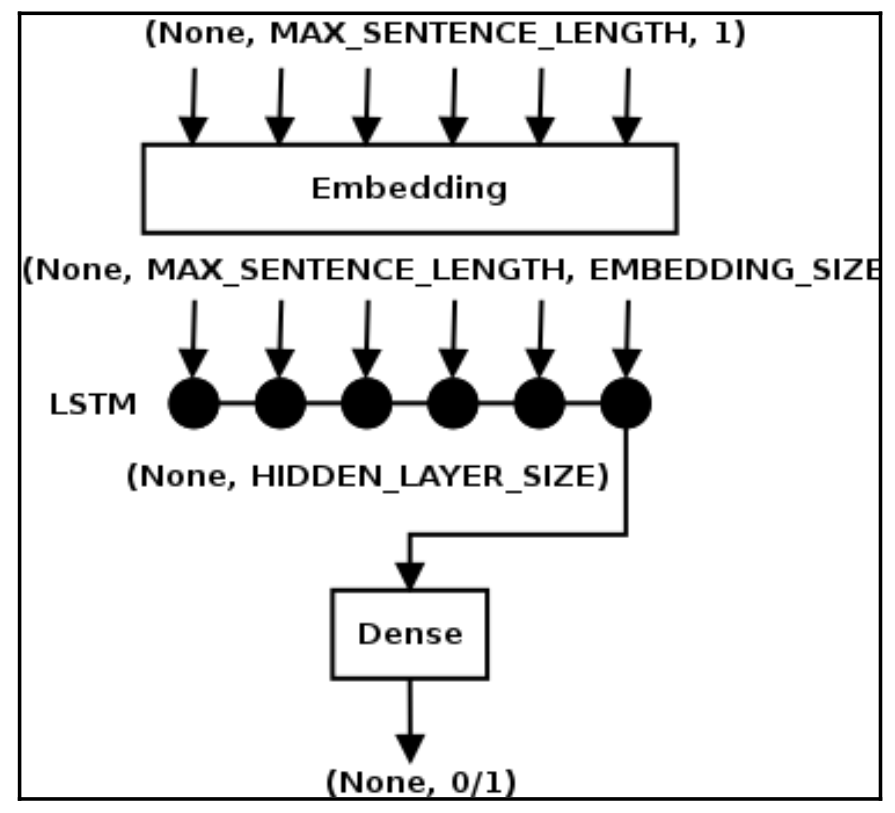

In [19]:
from IPython.display import Image
Image(filename='images/lstm_sentiment_analysis.png', width=400)

The input for each row is a sequence of word indices. The sequence length is given by `MAX_SENTENCE_LENGTH`. The first dimension of the tensor is set to `None` to indicate that the batch size (the number of records fed to the network each time) is currently unknown at definition time; it is specified during run time using the `batch_size` parameter. So assuming an as-yet undetermined batch size, the shape of the input tensor is (`None, MAX_SENTENCE_LENGTH, 1`). These tensors are fed into an embedding layer of size `EMBEDDING_SIZE` whose weights are initialized with small random values and learned during training. This layer will transform the tensor to a shape (`None,MAX_SENTENCE_LENGTH, EMBEDDING_SIZE`). The output of the embedding layer is fed into an LSTM with sequence length `MAX_SENTENCE_LENGTH` and output layer size `HIDDEN_LAYER_SIZE`, so the output of the LSTM is a tensor of shape (`None, HIDDEN_LAYER_SIZE, MAX_SENTENCE_LENGTH`). By default, the LSTM will output a single tensor of shape (`None, HIDDEN_LAYER_SIZE`) at its last sequence (`return_sequences=False`). This is fed to a dense layer with output size of 1 with a sigmoid activation function, so it will output either 0 (negative review) or 1 (positive review).

We compile the model using the `binary cross-entropy` loss function since it predicts a binary value, and the `Adam` optimizer, a good general purpose optimizer. Note that the hyperparameters `EMBEDDING_SIZE`, `HIDDEN_LAYER_SIZE`, `BATCH_SIZE` and `NUM_EPOCHS` (set as constants as follows) were tuned experimentally over several runs:

In [20]:
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10

In [25]:
# Build model
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_SENTENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(units=HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))

In [26]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

We then train the network for 10 epochs (`NUM_EPOCHS`) and batch size of 32 (`BATCH_SIZE`). At each epoch we validate the model using the validation data:

In [27]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_valid, y_valid))

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 22s 4ms/step - loss: 0.2545 - acc: 0.8850 - val_loss: 0.0685 - val_acc: 0.9788
Epoch 2/10
5668/5668 [==============================] - 20s 4ms/step - loss: 0.0347 - acc: 0.9896 - val_loss: 0.0412 - val_acc: 0.9831
Epoch 3/10
5668/5668 [==============================] - 20s 4ms/step - loss: 0.0086 - acc: 0.9977 - val_loss: 0.0340 - val_acc: 0.9908
Epoch 4/10
5668/5668 [==============================] - 20s 4ms/step - loss: 0.0038 - acc: 0.9996 - val_loss: 0.0381 - val_acc: 0.9894
Epoch 5/10
5668/5668 [==============================] - 20s 4ms/step - loss: 0.0041 - acc: 0.9988 - val_loss: 0.0427 - val_acc: 0.9887
Epoch 6/10
5668/5668 [==============================] - 20s 4ms/step - loss: 0.0039 - acc: 0.9991 - val_loss: 0.0407 - val_acc: 0.9901
Epoch 7/10
5668/5668 [==============================] - 20s 4ms/step - loss: 0.0031 - acc: 0.9995 - val_loss: 0.0431 - val_acc: 0.9894
Epoch 8

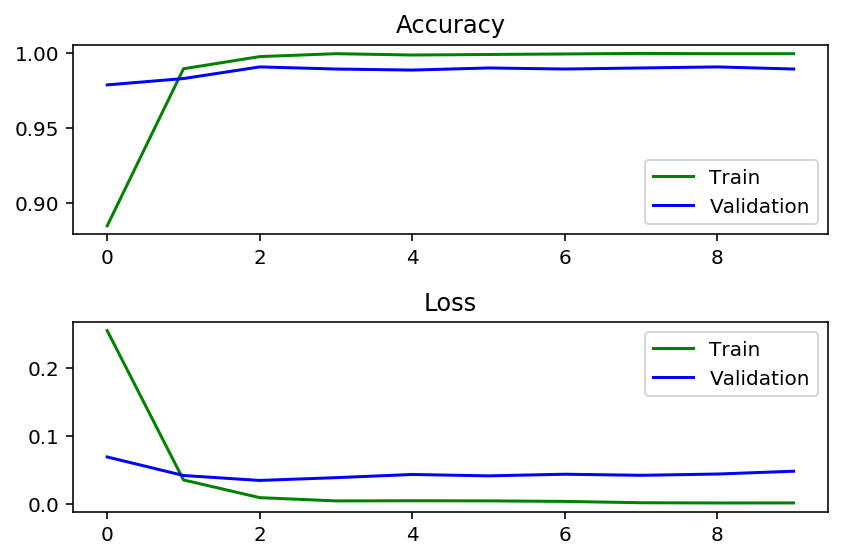

In [28]:
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
#plt.show()

Finally, we evaluate our model against the full test set and print the score and accuracy. We also pick a few random sentences from our test set and print the RNN's prediction, the label and the actual sentence:

In [29]:
# evaluate
score, acc = model.evaluate(X_valid, y_valid, batch_size=BATCH_SIZE)
print("Validation score: %.3f, accuracy: %.3f" % (score, acc))

1418/1418 [==============================] - 1s 744us/step
Validation score: 0.048, accuracy: 0.989


In [31]:
for i in range(5):
    idx = np.random.randint(len(X_valid))
    xtest = X_valid[idx].reshape(1,40)
    ylabel = y_valid[idx]
    ypred = model.predict(xtest)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print("%.0f\t%d\t%s" % (ypred, ylabel, sent))

0	0	da vinci code sucked..
1	1	i love being a sentry for mission impossible and a station for bonkers .
1	1	da vinci code was an awesome movie ...
1	1	the da vinci code was absolutely awesome !
1	1	i love being a sentry for mission impossible and a station for bonkers .


As you can see from the results, we get back close to 99% accuracy. The predictions the model makes for this particular set match exactly with the labels, although this is not the case for all predictions:

### Bidirectional RNNs 

At a given time step t, the output of the RNN is dependent on the outputs at all previous time steps. However, it is entirely possible that the output is also dependent on the future outputs as well. This is especially true for applications such as NLP, where the attributes of the word or phrase we are trying to predict may be dependent on the context given by the entire enclosing sentence, not just the words that came before it. Bidirectional RNNs also help a network architecture place equal emphasis on the beginning and end of the sequence, and increase the data available for training.

Bidirectional RNNs are two RNNs stacked on top of each other, reading the input in opposite directions. So in our example, one RNN will read the words left to right and the other RNN will read the words right to left. The output at each time step will be based on the hidden state of both RNNs.

Keras provides support for bidirectional RNNs through a bidirectional wrapper layer. For example, for our sentiment analysis example, we could make our LSTMs bidirectional simply by wrapping them with this Bidirectional wrapper, as shown in the model definition code as follows:

In [32]:
from keras.layers import Bidirectional
# Build model
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_SENTENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(units=HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1))
model.add(Activation("sigmoid"))

In [33]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_valid, y_valid))

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 43s 8ms/step - loss: 0.2552 - acc: 0.8809 - val_loss: 0.0824 - val_acc: 0.9753
Epoch 2/10
5668/5668 [==============================] - 39s 7ms/step - loss: 0.0352 - acc: 0.9882 - val_loss: 0.0385 - val_acc: 0.9866
Epoch 3/10
5668/5668 [==============================] - 39s 7ms/step - loss: 0.0109 - acc: 0.9970 - val_loss: 0.0375 - val_acc: 0.9873
Epoch 4/10
5668/5668 [==============================] - 39s 7ms/step - loss: 0.0052 - acc: 0.9988 - val_loss: 0.0438 - val_acc: 0.9894
Epoch 5/10
5668/5668 [==============================] - 38s 7ms/step - loss: 0.0044 - acc: 0.9989 - val_loss: 0.0434 - val_acc: 0.9880
Epoch 6/10
5668/5668 [==============================] - 39s 7ms/step - loss: 0.0026 - acc: 0.9995 - val_loss: 0.0529 - val_acc: 0.9873
Epoch 7/10
5668/5668 [==============================] - 38s 7ms/step - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0501 - val_acc: 0.9873
Epoch 8

In [34]:
# evaluate
score, acc = model.evaluate(X_valid, y_valid, batch_size=BATCH_SIZE)
print("Validation score: %.3f, accuracy: %.3f" % (score, acc))

1418/1418 [==============================] - 2s 1ms/step
Validation score: 0.058, accuracy: 0.987
